In [1]:
options(repr.plot.width  = 15, repr.plot.height = 10)

# Libraries

In [2]:
#install.packages("gbm")
#install.packages("xgboost")
#install.packages("doParallel")

In [3]:
library(dplyr)

# Modeling packages
library(caret)
library(gbm)      # for original implementation of regular and stochastic GBMs
library(xgboost)  # for fitting extreme gradient boosting
library(gridExtra)

library(doParallel)
library(vip)




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: ggplot2

Loaded gbm 2.1.8


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel


Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi




# Basic GBM

**Hyperparameters**
LA version simple de GBM tiene 2 tipos de hiper-parametros:
   * boosting
   * especificos de los arboles

**Hiper-parametros de Boosting**
* **Numero de arboles**: el numero total de arboles en la secuencia. A diferencia de Bagging y RF donde el numero de arboles raramente puede generar overfitting, en boosting el hecho de la dependencia con el error del arbol anterior lo hace propenso a hacer overfittig, en general este numero puede variar en dependencia de los otros hiper-pármetros.
* **Learning rate (shrinkage)**: determina la contribucion de cada arbon en el resultado final  y controla la velocidad con la que el algoritmo desciende. Este valor va entre $[0, 1]$ y valores tipicos van entre $0.001$ - $0.3$. Valores mas pequeños hacen mas robusto a caracteristicas especificas de cada arbol, permitiendo generalizaar bien. Sin embargo valores pequeños pueden llevar a no encontrar el punto optimo y quedar en un minimo local. Generalmente valores mas pequeños logran un performance mejor pero requiere de un numero mayor de arboles en la secuencia.

**Hiper-parametros propios de cada arbol**

* **Profundidad del arbol**: Controla el la profundida maxima de cada arbol. Los valores tipicos van entre 3-8 pero no es raro ver arboles con profundad 1. Valore bajos son computacionalmente eficiente pero requiren de mas arboles en toral. Sin embargo valores mas grandes permiten capturar interacciones entre las features pero lo hace propenso a hacer overfitting.
* **Numero minimo de observacioens en un nodo**: controla la complejidad del arbon. Dado que los arboles tienden a ser poco profundos tiende a tener poco efecto. Valore tipicos van entre 5-15. Valores grandes pueden ayudar a prevenir relaciones muy especificas entre variables (overfitting) pero para los casos de dataset desbalanceados valores pequeños pueden ayudar a detectar los casos de la clase minoritaria.

# Load data

In [4]:
ames <- AmesHousing::make_ames()

response <- "Sale_Price"
predictors <- setdiff(colnames(ames), response)

# Split Dataset

In [5]:
set.seed(123)
index_train <- createDataPartition(ames$Sale_Price, p = 0.8, 
                               list = FALSE, )
index_train  <- as.vector(index_train)

house_train <- ames[index_train, ]
house_test  <- ames[-index_train, ]

# Modeling
## Basic GBM model


In [6]:
set.seed(123)  # for reproducibility
ames_gbm1 <- gbm(
  formula = Sale_Price ~ .,
  data = house_train,
  distribution = "gaussian",  # SSE loss function
  n.trees = 5000,  # default = 100
  shrinkage = 0.1,  # default = 0.1
  interaction.depth = 3,  # max tree depth
  n.minobsinnode = 10,  # min obserbation in a node
#  bag.fraction = 0.5,
#  train.fraction = 0.8,
  cv.folds = 10
)

# Busca el numero de arboles que genera el menor error en train
best <- which.min(ames_gbm1$cv.error)

# calcula el RMSE de train para el numero de arboles con el minimo MSE
sqrt(ames_gbm1$cv.error[best])
## [1] 23240.38

[1] 22342.89

## Plot error curve and find the optimum iteration

[1] 823

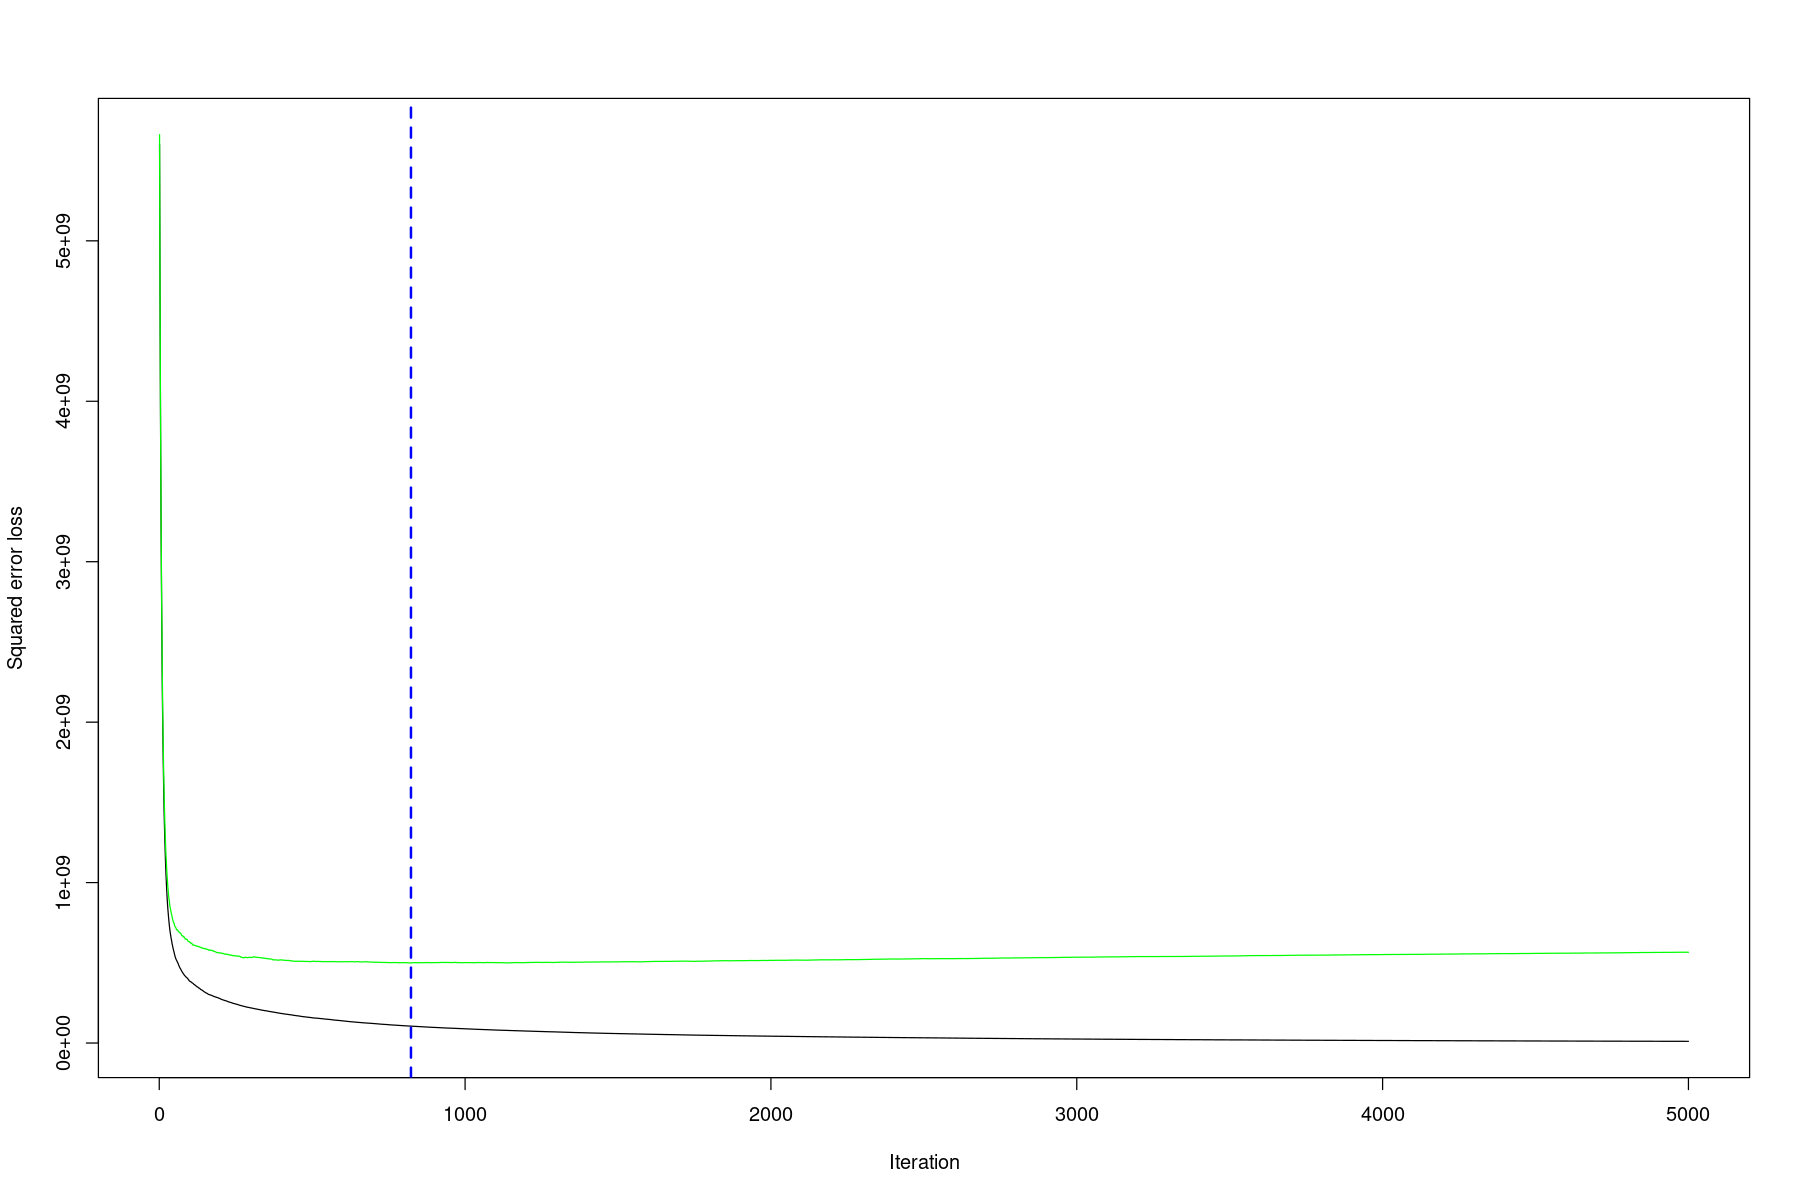

In [10]:
gbm.perf(ames_gbm1, method = "cv")

## Predictions
Hay algunas diferencias en la forma en la que se hacen las predicciones con nuevos datos usando GBM, ademas de dar el modelo y los nuevos datos podemos indicar el numero de iteraciones (numero de arboles) para la prediccion, por defecto usa el que resulto de gbm.perf(..., method=CV). Adicionalmente podemos definir el tipo de respuesta ("response", "prob")

[documentación](https://www.rdocumentation.org/packages/gbm/versions/2.1.8/topics/predict.gbm)

In [28]:
RMSE(pred = predict(ames_gbm1, newdata = house_test, n.trees = NULL, type = 'response'),
     obs = house_test$Sale_Price)

Using 823 trees...




[1] 21552.56

# General tuning strategy

Unlike random forests, GBMs can have high variability in accuracy dependent on their hyperparameter settings (Probst, Bischl, and Boulesteix 2018). So tuning can require much more strategy than a random forest model. Often, a good approach is to:

* Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05–0.2 should work across a wide range of problems.
* Determine the optimum number of trees for this learning rate.
* Fix tree hyperparameters and tune learning rate and assess speed vs. performance.
* Tune tree-specific parameters for decided learning rate.
* Once tree-specific parameters have been found, lower the learning rate to assess for any improvements in accuracy.
* Use final hyperparameter settings and increase CV procedures to get more robust estimates. Often, the above steps are performed with a simple validation procedure or 5-fold CV due to computational constraints. If you used k-fold CV throughout steps 1–5 then this step is not necessary.


In [ ]:
is_trian <- FALSE

if (is_trian){
    gbmGrid <-  expand.grid(interaction.depth = 3,
                            n.trees = 2000, 
                            shrinkage = c(0.3, 0.1, 0.05, 0.01, 0.005),
                            n.minobsinnode = 10)

    fitControl <- trainControl(method = "cv",
                               number = 5,
                               allowParallel = TRUE
                              )                        

    cl <- makePSOCKcluster(detectCores() - 1)
    registerDoParallel(cl)
    set.seed(42)
    gbmFit2 <- train(Sale_Price ~ .,
                     data = ames, 
                     method = "gbm", 
                     distribution = "gaussian",
                     bag.fraction = 0.7,
                     train.fraction = 1,
                     trControl = fitControl, 
                     verbose = TRUE, 
                     tuneGrid = gbmGrid
                    )
    stopCluster(cl)
    saveRDS(gbmFit2, "models/gbm_house_fit2.rds")
    gbmFit2    
}


In [ ]:
gbmFit2 <- readRDS("models/gbm_house_fit2.rds")

In [ ]:
plot(gbmFit2)

# Stochastic GBMs
An important insight made by Breiman (Breiman (1996a); Breiman (2001)) in developing his bagging and random forest algorithms was that training the algorithm on a random subsample of the training data set offered additional reduction in tree correlation and, therefore, improvement in prediction accuracy. Friedman (2002) used this same logic and updated the boosting algorithm accordingly. This procedure is known as stochastic gradient boosting and, as illustrated in Figure 12.5, helps reduce the chances of getting stuck in local minimas, plateaus, and other irregular terrain of the loss function so that we may find a near global optimum.
12.4.1 Stochastic hyperparameters

There are a few variants of stochastic gradient boosting that can be used, all of which have additional hyperparameters:

- Subsample rows before creating each tree (available in gbm, h2o, & xgboost)
- Subsample columns before creating each tree (h2o & xgboost)
- Subsample columns before considering each split in each tree (h2o & xgboost)

Generally, aggressive subsampling of rows, such as selecting only 50% or less of the training data, has shown to be beneficial and typical values range between 0.5–0.8. Subsampling of columns and the impact to performance largely depends on the nature of the data and if there is strong multicollinearity or a lot of noisy features. Similar to the mtry

parameter in random forests (Section 11.4.2), if there are fewer relevant predictors (more noisy data) higher values of column subsampling tends to perform better because it makes it more likely to select those features with the strongest signal. When there are many relevant predictors, a lower values of column subsampling tends to perform well.

When adding in a stochastic procedure, you can either include it in step 4) in the general tuning strategy above (Section 12.3.3), or once you’ve found the optimal basic model (after 6)). In our experience, we have not seen strong interactions between the stochastic hyperparameters and the other boosting and tree-specific hyperparameters.

XGBoost

Extreme gradient boosting (XGBoost) is an optimized distributed gradient boosting library that is designed to be efficient, flexible, and portable across multiple languages (Chen and Guestrin 2016). Although XGBoost provides the same boosting and tree-based hyperparameter options illustrated in the previous sections, it also provides a few advantages over traditional boosting such as:

* Regularization: XGBoost offers additional regularization hyperparameters, which we will discuss shortly, that provides added protection against overfitting.
* Early stopping: Similar to h2o, XGBoost implements early stopping so that we can stop model assessment when additional trees offer no improvement.
* Parallel Processing: Since gradient boosting is sequential in nature it is extremely difficult to parallelize. XGBoost has implemented procedures to support GPU and Spark compatibility which allows you to fit gradient boosting using powerful distributed processing engines.
* Loss functions: XGBoost allows users to define and optimize gradient boosting models using custom objective and evaluation criteria.
* Continue with existing model: A user can train an XGBoost model, save the results, and later on return to that model and continue building onto the results. Whether you shut down for the day, wanted to review intermediate results, or came up with additional hyperparameter settings to evaluate, this allows you to continue training your model without starting from scratch.
* Different base learners: Most GBM implementations are built with decision trees but XGBoost also provides boosted generalized linear models.
* Multiple languages: XGBoost offers implementations in R, Python, Julia, Scala, Java, and C++.

In addition to being offered across multiple languages, XGboost can be implemented multiple ways within R. The main R implementation is the xgboost package; however, as illustrated throughout many chapters one can also use caret as a meta engine to implement XGBoost. The h2o package also offers an implementation of XGBoost. In this chapter we’ll demonstrate the xgboost package.

## XGBoost hyperparameters
### Regularizacion
* gamma: is a pseudo-regularization hyperparameter known as a Lagrangian multiplier and controls the complexity of a given tree. gamma specifies a minimum loss reduction required to make a further partition on a leaf node of the tree. When gamma is specified, xgboost will grow the tree to the max depth and then prune the tree. ranges from 0−∞ (0 means no constraint while large numbers mean a higher regularization). What quantifies as a large gamma value is dependent on the loss function but generally lower values between 1–20 will do if gamma is influential.
* alpha: L1 
* lambda: L2
### Dropout
Dropout is an alternative approach to reduce overfitting and can loosely be described as regularization. The dropout approach developed by Srivastava et al. (2014a) has been widely employed in deep learnings to prevent deep neural networks from overfitting (see Section 13.7.3). Dropout can also be used to address overfitting in GBMs. When constructing a GBM, the first few trees added at the beginning of the ensemble typically dominate the model performance while trees added later typically improve the prediction for only a small subset of the feature space. This often increases the risk of overfitting and the idea of dropout is to build an ensemble by randomly dropping trees in the boosting sequence. This is commonly referred to as DART (Rashmi and Gilad-Bachrach 2015) since it was initially explored in the context of Mutliple Additive Regression Trees (MART); DART refers to Dropout Additive Regression Trees. The percentage of dropouts is another regularization parameter.

Typically, when gamma, alpha, or lambda cannot help to control overfitting, exploring DART hyperparameters would be the next best option.33

### Tuning strategy

The general tuning strategy for exploring xgboost hyperparameters builds onto the basic and stochastic GBM tuning strategies:

    Crank up the number of trees and tune learning rate with early stopping
    Tune tree-specific hyperparameters
    Explore stochastic GBM attributes
    If substantial overfitting occurs (e.g., large differences between train and CV error) explore regularization hyperparameters
    If you find hyperparameter values that are substantially different from default settings, be sure to retune the learning rate
    Obtain final “optimal” model

Running an XGBoost model with xgboost requires some additional data preparation. xgboost requires a matrix input for the features and the response to be a vector. Consequently, to provide a matrix input of the features we need to encode our categorical variables numerically (i.e. one-hot encoding, label encoding). The following numerically label encodes all categorical features and converts the training data frame to a matrix.


|Model|Method|Type|Libraries|Tuning Parameters|
|---|---|---|---|---|
|eXtreme Gradient Boosting|xgbDART|Classification, Regression|xgboost, plyr|nrounds, max_depth, eta, gamma, subsample, colsample_bytree, rate_drop, skip_drop, min_child_weight|
|eXtreme Gradient Boosting|xgbLinear|Classification, Regression|xgboost|nrounds, lambda, alpha, eta|
|eXtreme Gradient Boosting|xgbTree|Classification, Regression|xgboost, plyr|nrounds, max_depth, eta, gamma, colsample_bytree, min_child_weight, subsample|
<img src=https://scikit-learn.org/stable/_images/sphx_glr_plot_gradient_boosting_regularization_001.png>

In [ ]:
library(recipes)
xgb_prep <- recipe(Sale_Price ~ ., data = house_train) %>%
  step_integer(all_nominal()) %>%
  prep(training = house_train, retain = TRUE) %>%
  juice()

X <- as.matrix(xgb_prep[setdiff(names(xgb_prep), "Sale_Price")])
Y <- xgb_prep$Sale_Price

In [ ]:
set.seed(123)
ames_xgb <- xgb.cv(
  data = X,
  label = Y,
  nrounds = 6000,
  objective = "reg:squarederror",
  early_stopping_rounds = 50, 
  nfold = 10,
  params = list(
    eta = 0.1,
    max_depth = 3,
    min_child_weight = 3,
    subsample = 0.8,
    colsample_bytree = 1.0),
  verbose = 0
)  

# minimum test CV RMSE
min(ames_xgb$evaluation_log$test_rmse_mean)
## [1] 20488

In [ ]:
# hyperparameter grid
hyper_grid <- expand.grid(
  eta = 0.01,
  max_depth = 3, 
  min_child_weight = 3,
  subsample = 0.5, 
  colsample_bytree = 0.5,
  gamma = c(0, 1, 10, 100, 1000),
  lambda = c(0, 1e-2, 0.1, 1, 100, 1000, 10000),
  alpha = c(0, 1e-2, 0.1, 1, 100, 1000, 10000),
  rmse = 0,          # a place to dump RMSE results
  trees = 0          # a place to dump required number of trees
)

# grid search
for(i in seq_len(nrow(hyper_grid))) {
  set.seed(123)
  m <- xgb.cv(
    data = X,
    label = Y,
    nrounds = 4000,
    objective = "reg:squarederror",
    early_stopping_rounds = 50, 
    nfold = 10,
    verbose = 0,
    params = list( 
      eta = hyper_grid$eta[i], 
      max_depth = hyper_grid$max_depth[i],
      min_child_weight = hyper_grid$min_child_weight[i],
      subsample = hyper_grid$subsample[i],
      colsample_bytree = hyper_grid$colsample_bytree[i],
      gamma = hyper_grid$gamma[i], 
      lambda = hyper_grid$lambda[i], 
      alpha = hyper_grid$alpha[i]
    ) 
  )
  hyper_grid$rmse[i] <- min(m$evaluation_log$test_rmse_mean)
  hyper_grid$trees[i] <- m$best_iteration
}

# results
hyper_grid %>%
  filter(rmse > 0) %>%
  arrange(rmse) %>%
  glimpse()

In [ ]:
# optimal parameter list
params <- list(
  eta = 0.01,
  max_depth = 3,
  min_child_weight = 3,
  subsample = 0.5,
  colsample_bytree = 0.5
)

# train final model
xgb.fit.final <- xgboost(
  params = params,
  data = X,
  label = Y,
  nrounds = 3944,
  objective = "reg:squarederror",
  verbose = 0
)

In [ ]:
plot(xgb.fit.final$evaluation_log$train_rmse)

### Feature interpretation

Measuring GBM feature importance and effects follows the same construct as random forests. Similar to random forests, the gbm and h2o packages offer an impurity-based feature importance. xgboost actually provides three built-in measures for feature importance:

    Gain: This is equivalent to the impurity measure in random forests (reference Section 11.6) and is the most common model-centric metric to use.
    Coverage: The Coverage metric quantifies the relative number of observations influenced by this feature. For example, if you have 100 observations, 4 features and 3 trees, and suppose x1

is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2=17
observations. This will be calculated for all the 4 features and expressed as a percentage.
Frequency: The percentage representing the relative number of times a particular feature occurs in the trees of the model. In the above example, if x1
was used for 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3 respectively; then the weightage for x1 will be 2+1+3=6. The frequency for x1 is calculated as its percentage weight over weights of all xp features.

If we examine the top 10 influential features in our final model using the impurity (gain) metric, we see very similar results as we saw with our random forest model (Section 11.6). The primary difference is we no longer see Neighborhood as a top influential feature, which is likely a result of how we label encoded the categorical features.

In [ ]:
importances <- xgb.importance(model=xgb.fit.final)

In [ ]:
head(importances)

In [ ]:
vip::vip(xgb.fit.final, type="gain", num_features = 25)

In [ ]:
vip::vip(xgb.fit.final, type="cover", num_features = 25)

In [ ]:
vip::vip(xgb.fit.final, type="frequency", num_features = 25)